# Statsmodels buat ngecek regresi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',False)
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv('data_bersih.csv')
df = df.drop(['Unnamed: 0', 'index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13514 entries, 0 to 13513
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    13514 non-null  int64  
 1   kamar_tidur    13514 non-null  int64  
 2   luas_bangunan  13514 non-null  float64
 3   luas_tanah     13514 non-null  float64
 4   harga          13514 non-null  float64
 5   kecamatan      13514 non-null  object 
 6   garasi         13514 non-null  bool   
 7   kolam_renang   13514 non-null  bool   
 8   taman          13514 non-null  bool   
 9   gym            13514 non-null  bool   
 10  jumlah_lantai  13514 non-null  int64  
 11  listrik        13514 non-null  float64
dtypes: bool(4), float64(4), int64(3), object(1)
memory usage: 897.5+ KB


In [3]:
num = [i for i in df.columns if df[i].dtypes in ['int64', 'float']]
cat = [i for i in df.columns if df[i].dtypes in ['O', 'bool']]

In [4]:
df[cat] = df[cat].astype('O')

In [5]:
from feature_engine.encoding import DecisionTreeEncoder as DTE

In [6]:
#np.bool ga ada?
encode = DTE(variables = ['kecamatan'])
encode.fit(df,df['harga'])

DecisionTreeEncoder(param_grid={'max_depth': [1, 2, 3, 4]},
                    variables=['kecamatan'])

In [7]:
from feature_engine.encoding import OrdinalEncoder as OE

In [8]:
oe = OE(variables = ['garasi','kolam_renang','taman','gym'])
oe.fit(df,df['harga'])

OrdinalEncoder(variables=['garasi', 'kolam_renang', 'taman', 'gym'])

In [9]:
import statsmodels.api as sm

In [10]:
y = df['harga']
x = oe.transform(encode.transform(df))
x = sm.add_constant(x)
x_st = x.drop('harga',axis =1)

In [11]:
model = sm.OLS(y, x_st).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  harga   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     2518.
Date:                Thu, 20 May 2021   Prob (F-statistic):               0.00
Time:                        13:05:50   Log-Likelihood:            -3.2738e+05
No. Observations:               13514   AIC:                         6.548e+05
Df Residuals:                   13502   BIC:                         6.549e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.419e+09   3.05e+08    -14.503      0.000   -5.02e+09   -3.82e+09
kamar_mandi     1.31e+07   5.44e+07      0.241      0.810   -9.35e+07     1.2e+08
kamar_tidur   -1.864e+08   4.15e+07     -4.491      0.000   -2.68e+08   -1.05e+08
luas_bangunan  1.926e+07   4.12e+05     46.709      0.000    1.85e+07    2.01e+07
luas_tanah     1.238e+07   3.48e+05     35.527      0.000    1.17e+07    1.31e+07
kecamatan         0.6398      0.009     74.128      0.000       0.623       0.657
garasi        -3.204e+08    2.1e+08     -1.526      0.127   -7.32e+08    9.12e+07
kolam_renang   5.495e+08    2.3e+08      2.385      0.017    9.78e+07       1e+09
taman          8.919e+07   1.71e+08      0.522      0.602   -2.46e+08    4.24e+08
gym            1.869e+09    7.2e+08      2.595      0.009    4.57e+08    3.28e+09
jumlah_lantai -2.676e+08   1.12e+08     -2.394      0.017   -4.87e+08   -4.85e+07
listrik        7.678e+04   8396.774      9.144      0.000    6.03e+04    9.32e+04
==============================================================================
Omnibus:                    17266.191   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25505644.366
Skew:                           6.247   Prob(JB):                         0.00
Kurtosis:                     215.462   Cond. No.                     1.19e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Kamar mandi, garasi dan taman bukan merupakan variabel yang berpengaruh terhadap regresi(khusus pada dataset ini)

nilai r2nya ga buruk2 amat lah untuk real dataset jadi masih bisa dipake

In [13]:
from scipy import stats

In [14]:
for k in cat+num:
    if df[k].nunique() <100:
        print("="*45,f' {k} ',"="*45)
        var = [i for i in df[k].unique()]
        pair = {}
        udah = []
        for i in var:
            for j in var:
                if (j not in udah) & (i != j):
                    ttest = stats.ttest_ind(a = df[df[k] == i]['harga'],
                                            b = df[df[k] == j]['harga'])
                    p_value = ttest.pvalue
                    pair[f'{i} - {j}'] = p_value
            udah.append(i)
        count = 0
        for i,j in pair.items():
            if j >= 0.05:
                print(i)
                count += 1
        print(f'{k}: {count/len(pair)*100}')
        print("="*100,end = '\n')

=============================================  kecamatan  =============================================
Cilandak - Tebet
Cilandak - Pasar Minggu
Cilandak - Pancoran
Cilandak - Gambir
Kebayoran Baru - Kebayoran Lama
Kebayoran Baru - Setiabudi
Jagakarsa - Koja
Jagakarsa - Cakung
Jagakarsa - Kramat Jati
Jagakarsa - Makasar
Jagakarsa - Kalideres
Jagakarsa - Cengkareng
Tebet - Pasar Minggu
Tebet - Jatinegara
Tebet - Senen
Tebet - Gambir
Tebet - Palmerah
Pasar Minggu - Pancoran
Pasar Minggu - Jatinegara
Pasar Minggu - Senen
Pasar Minggu - Gambir
Pasar Minggu - Palmerah
Kebayoran Lama - Setiabudi
Pesanggrahan - Tanjung Priok
Pesanggrahan - Kelapa Gading
Pesanggrahan - Pademangan
Pesanggrahan - Pulo Gadung
Pesanggrahan - Matraman
Pesanggrahan - Jatinegara
Pesanggrahan - Senen
Pesanggrahan - Kemayoran
Pesanggrahan - Cempaka Putih
Pesanggrahan - Sawah Besar
Pesanggrahan - Johar Baru
Pesanggrahan - Palmerah
Pesanggrahan - Kembangan
Pesanggrahan - Kebon Jeruk
Pesanggrahan - Taman Sari
Pesanggrahan

statistical significance kamar_tidur(70) dan kamar_mandi(50) ga terlalu ketara (sekali lagi cuma di dataset ini!!!).

# EDA

kamar_mandi


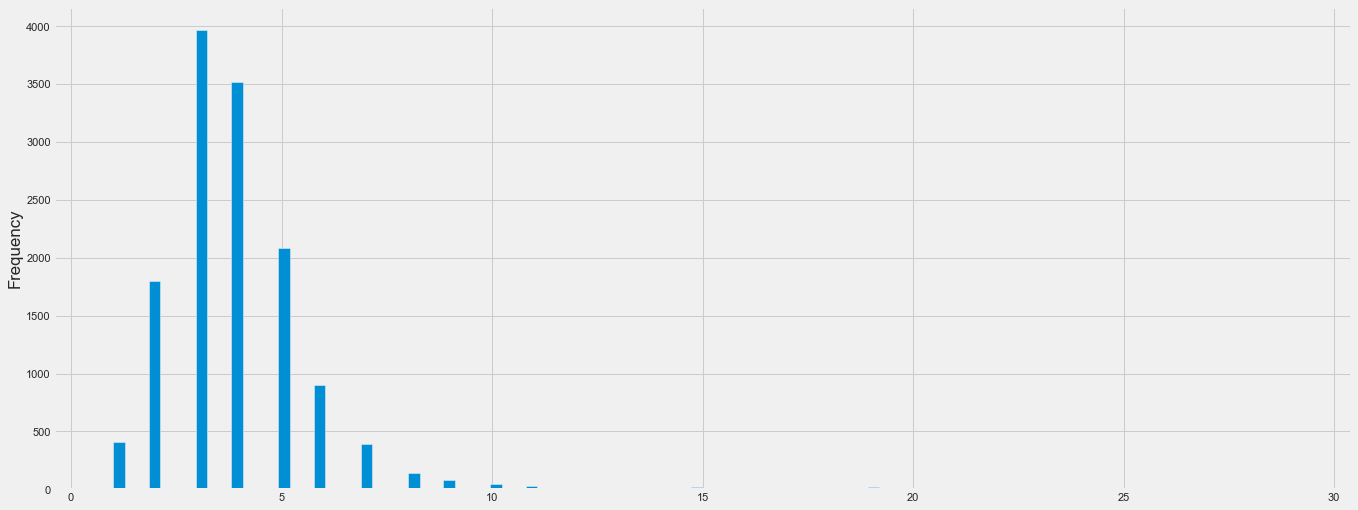

kamar_tidur


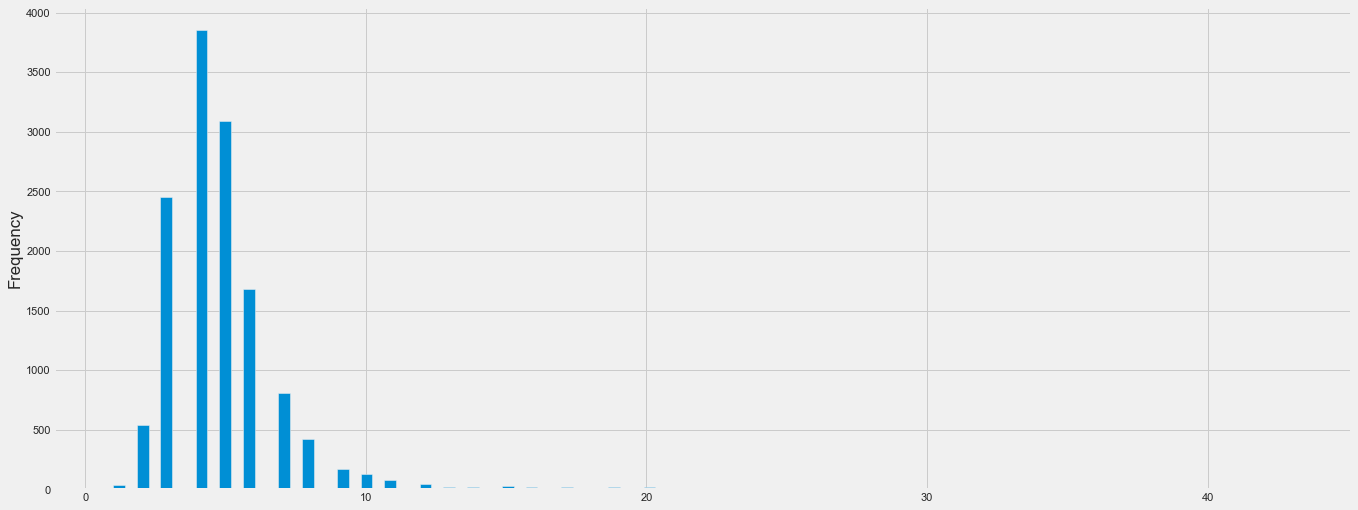

luas_bangunan


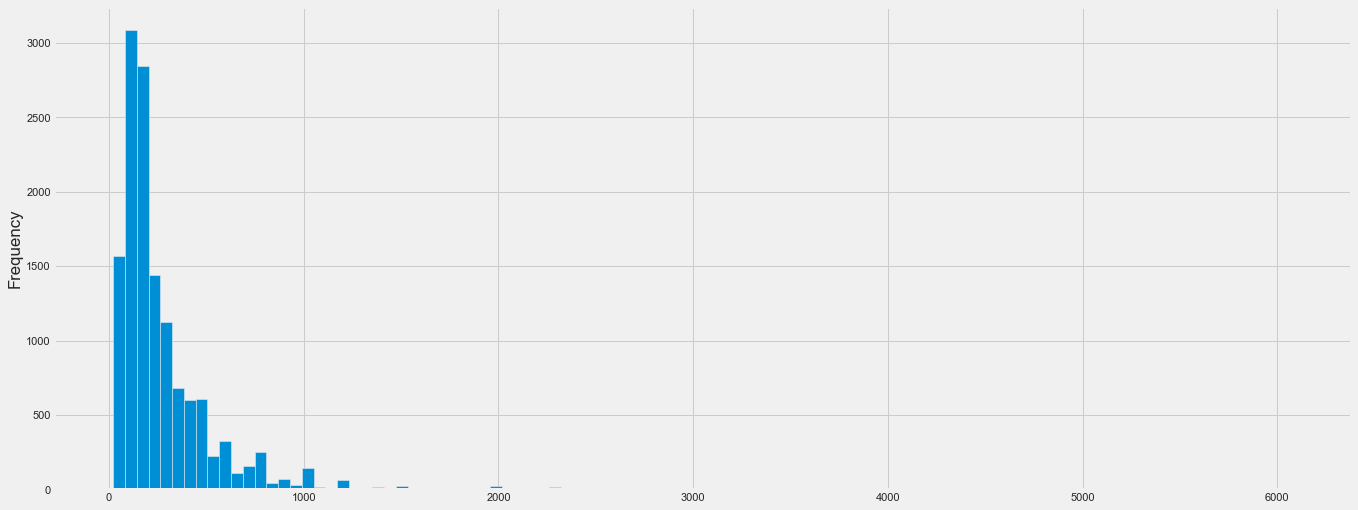

luas_tanah


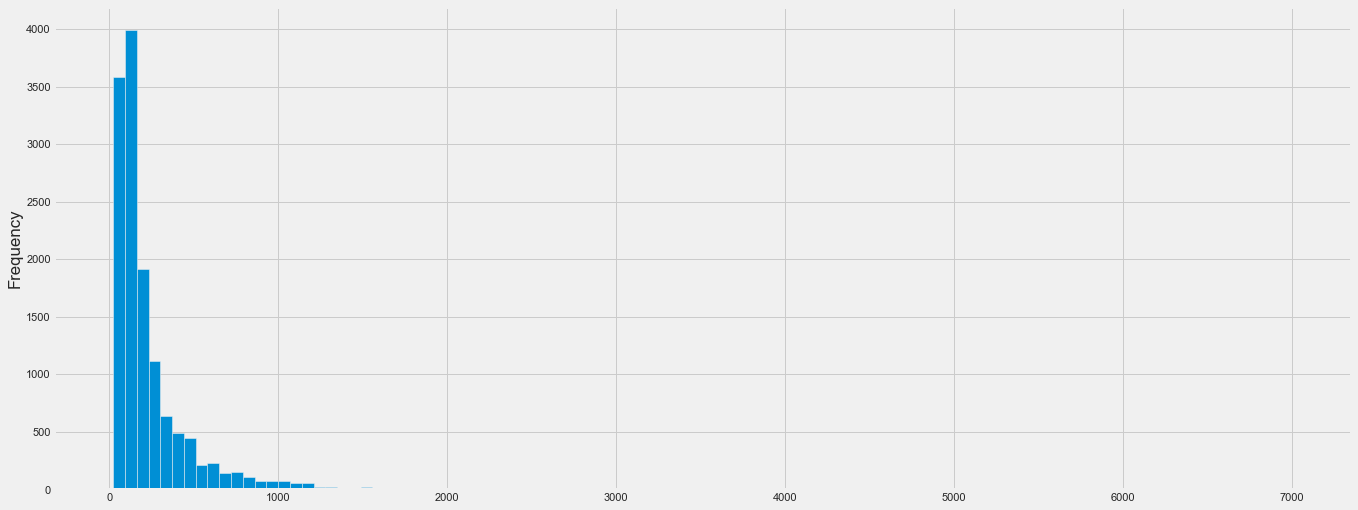

harga


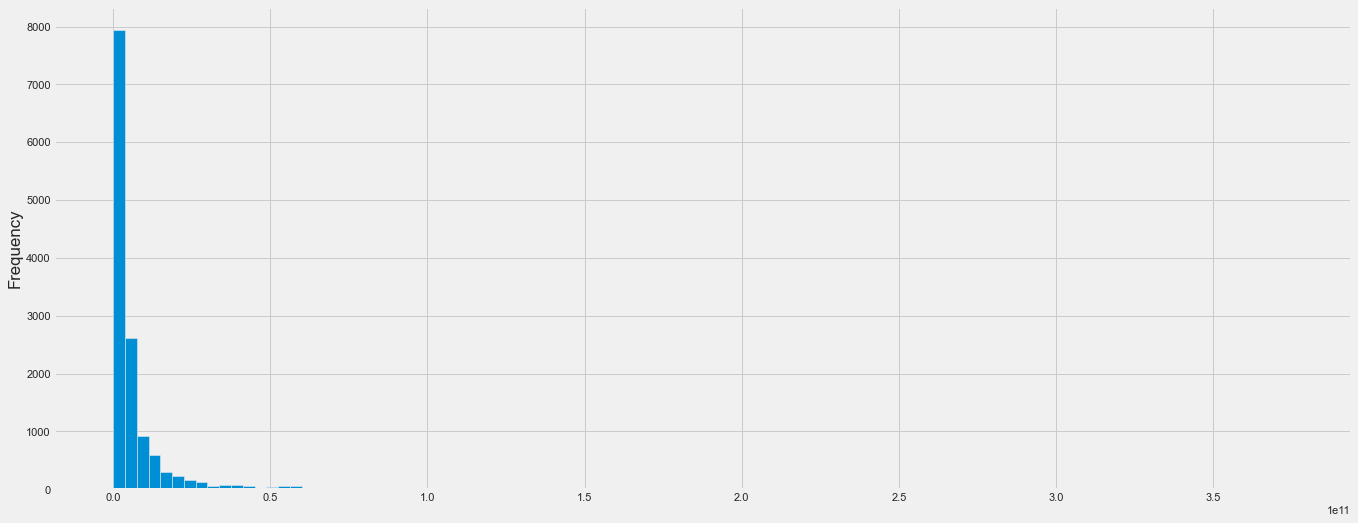

jumlah_lantai


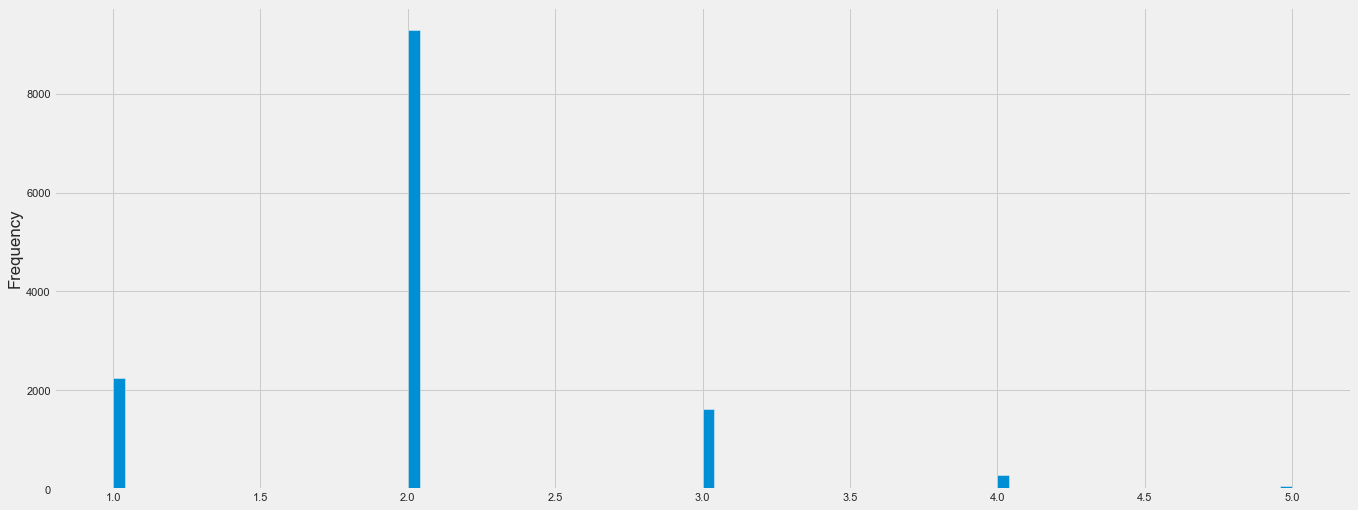

listrik


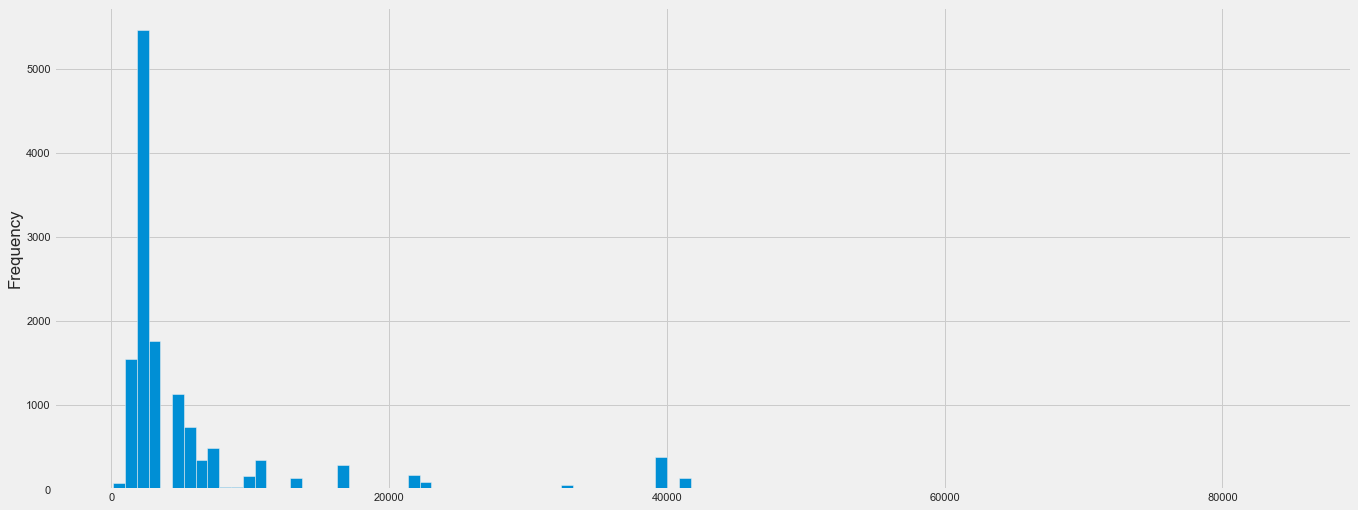

In [15]:
for i in num:
    print(i)
    df[i].plot.hist(bins = 100)
    plt.show()

kamar_mandi


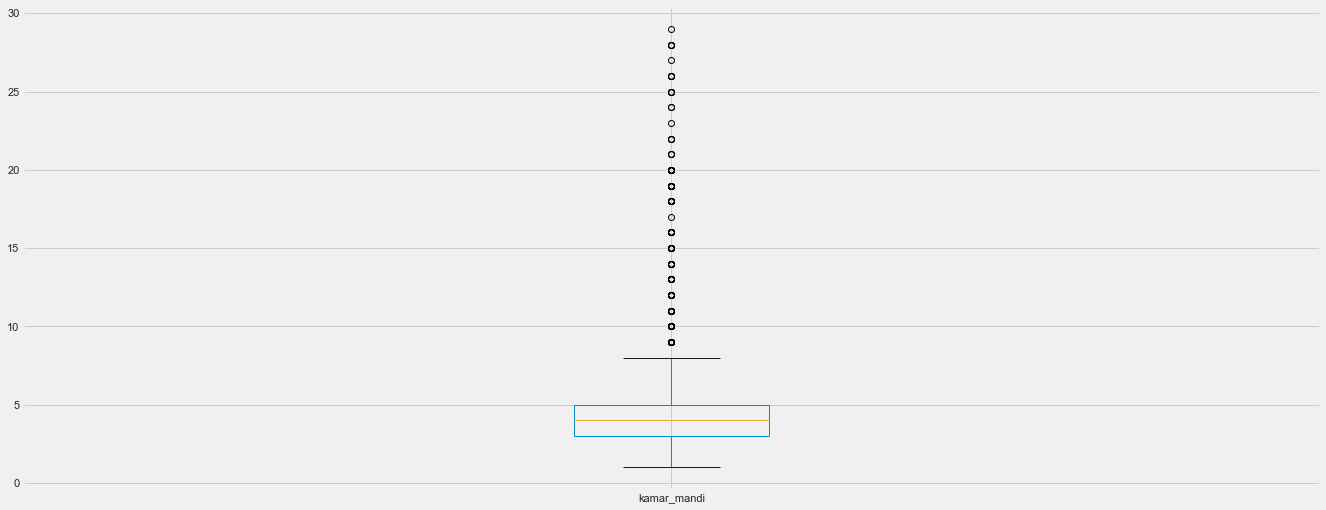

kamar_tidur


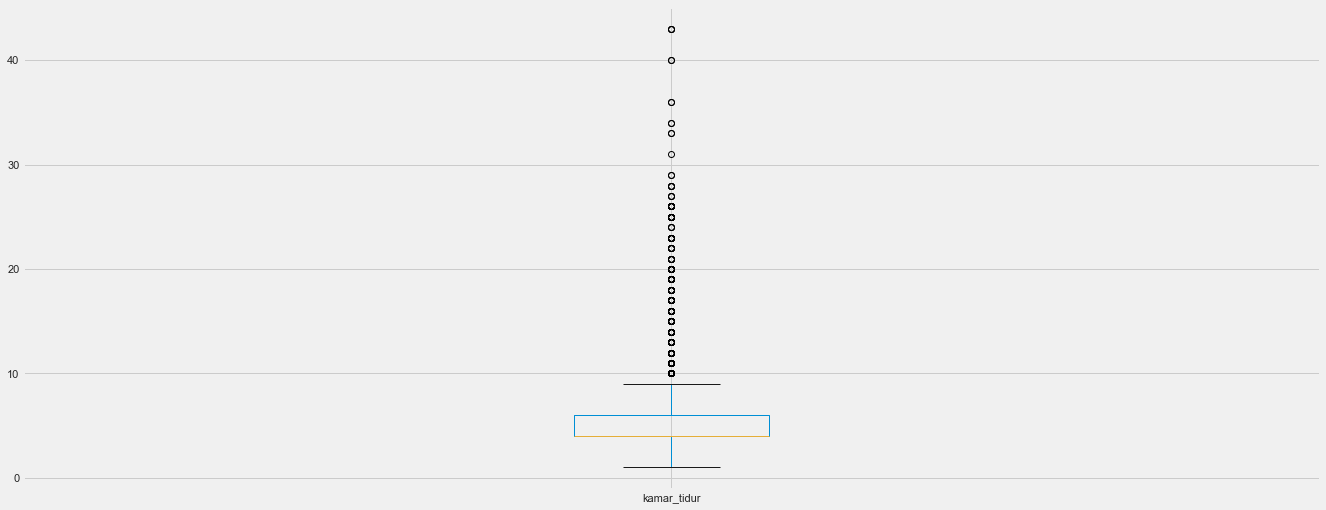

luas_bangunan


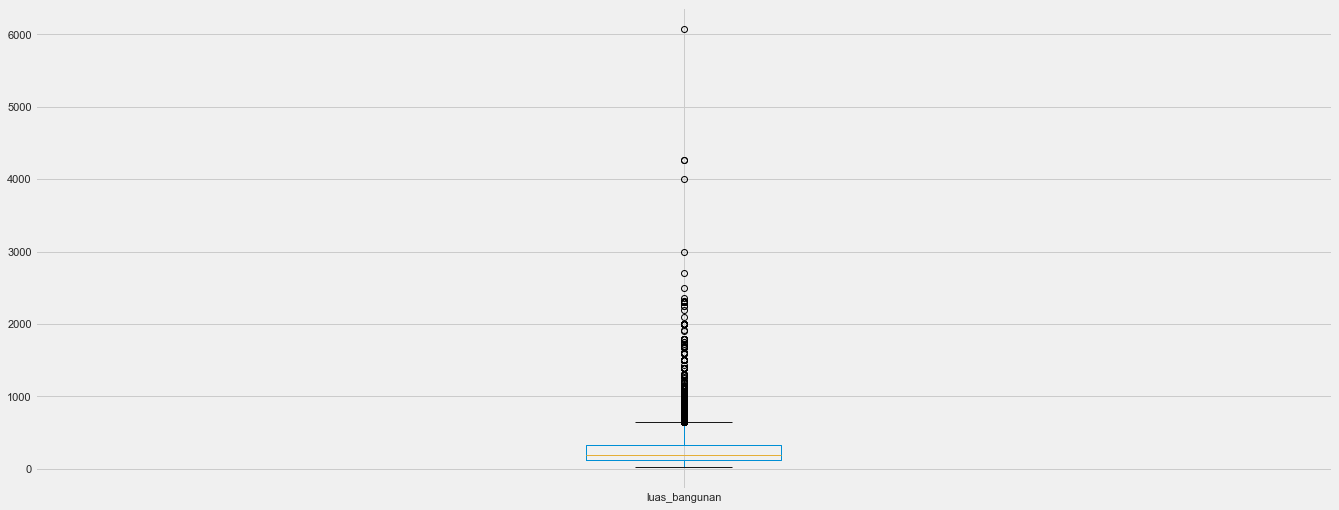

luas_tanah


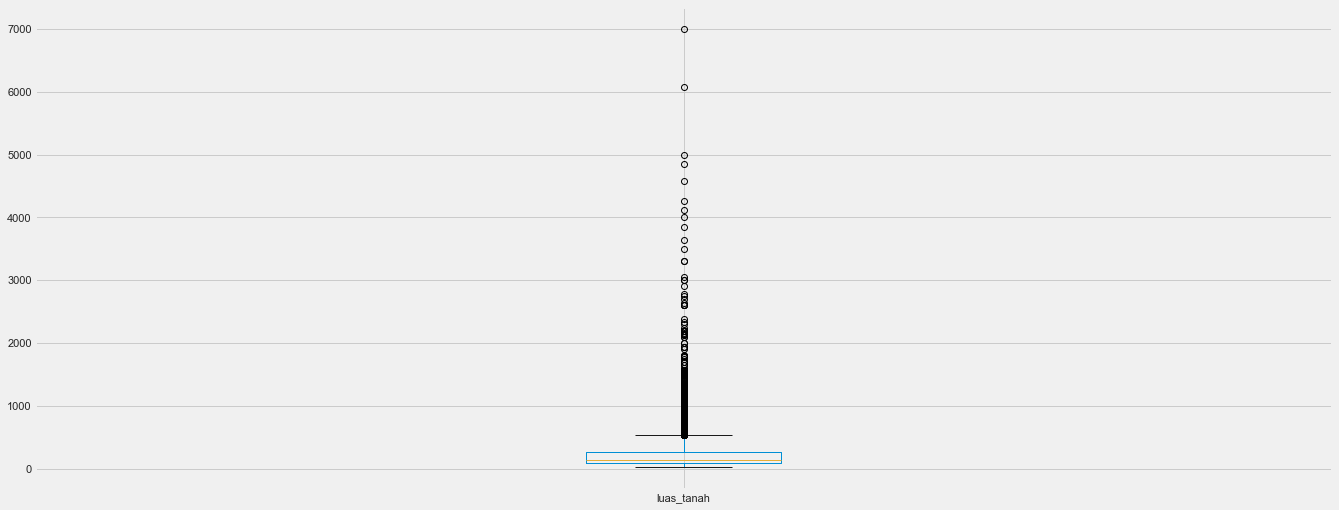

harga


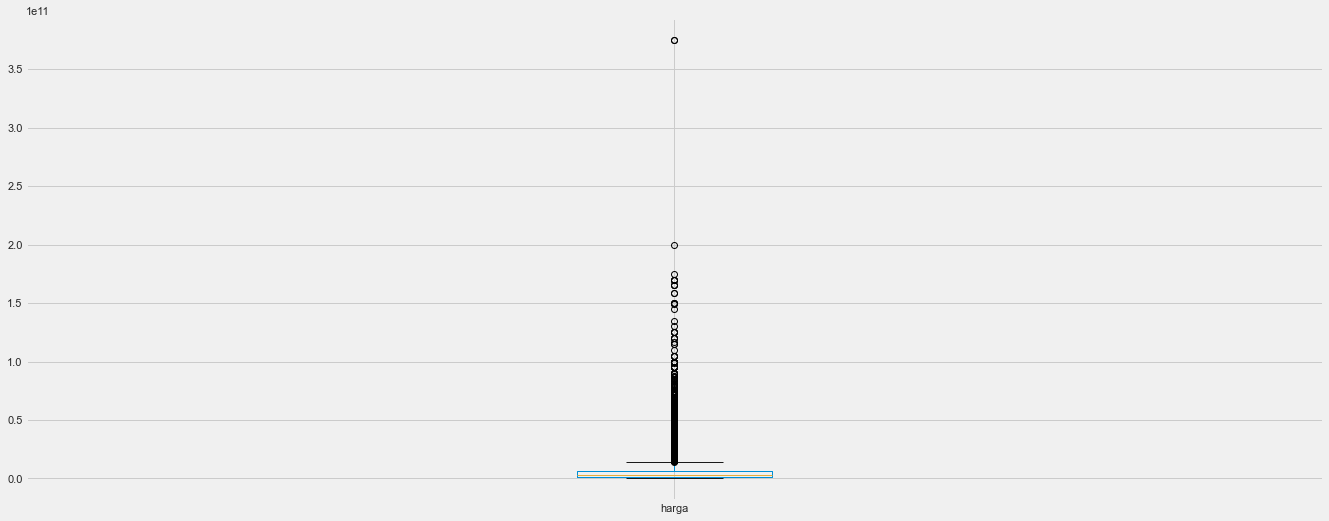

jumlah_lantai


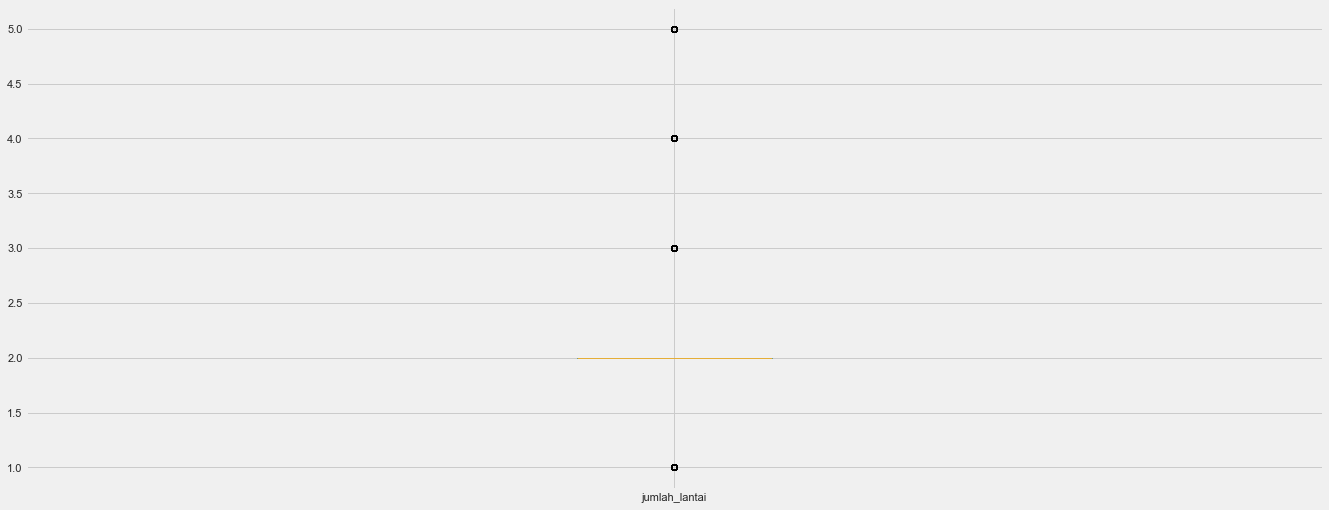

listrik


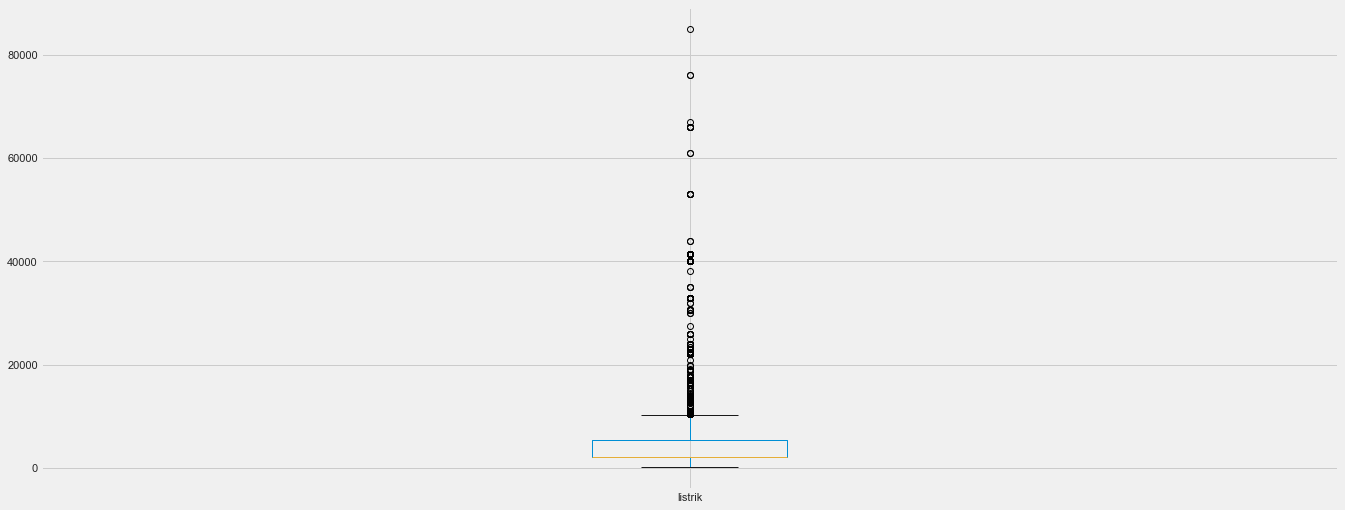

In [16]:
for i in num:
    print(i)
    df[i].plot.box()
    plt.show()

kecamatan


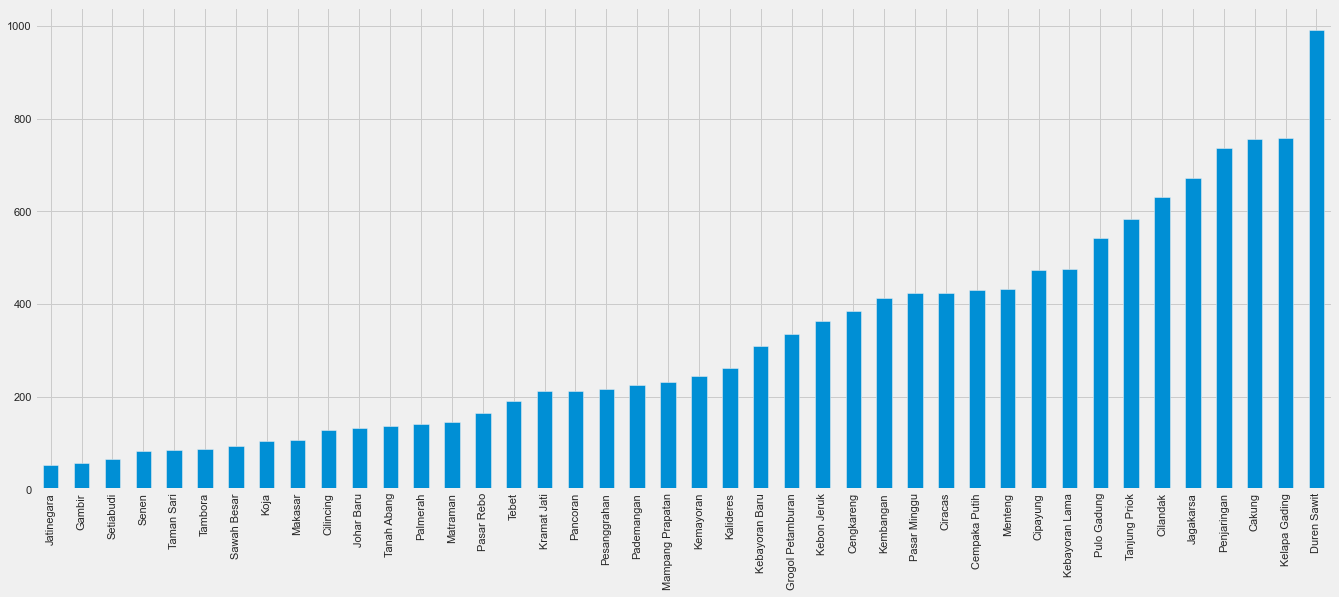

garasi


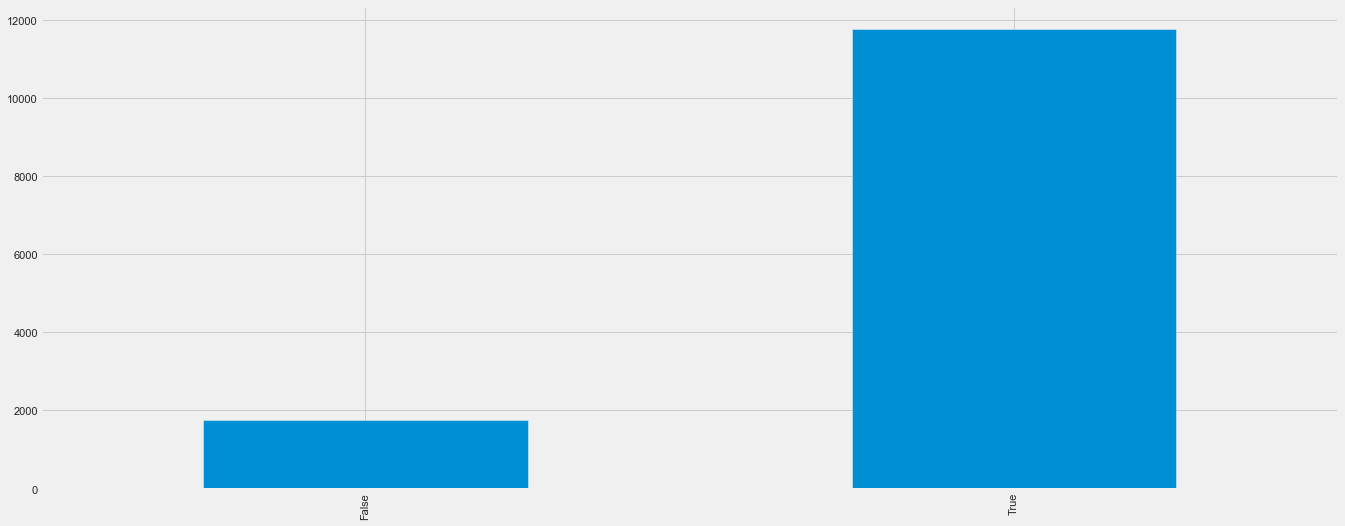

kolam_renang


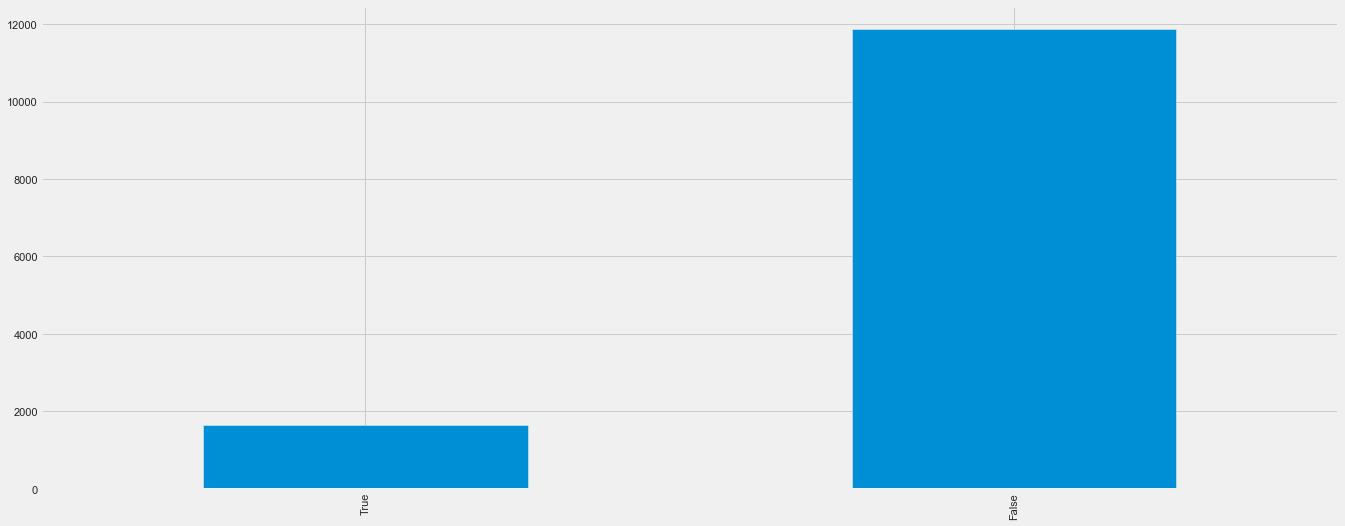

taman


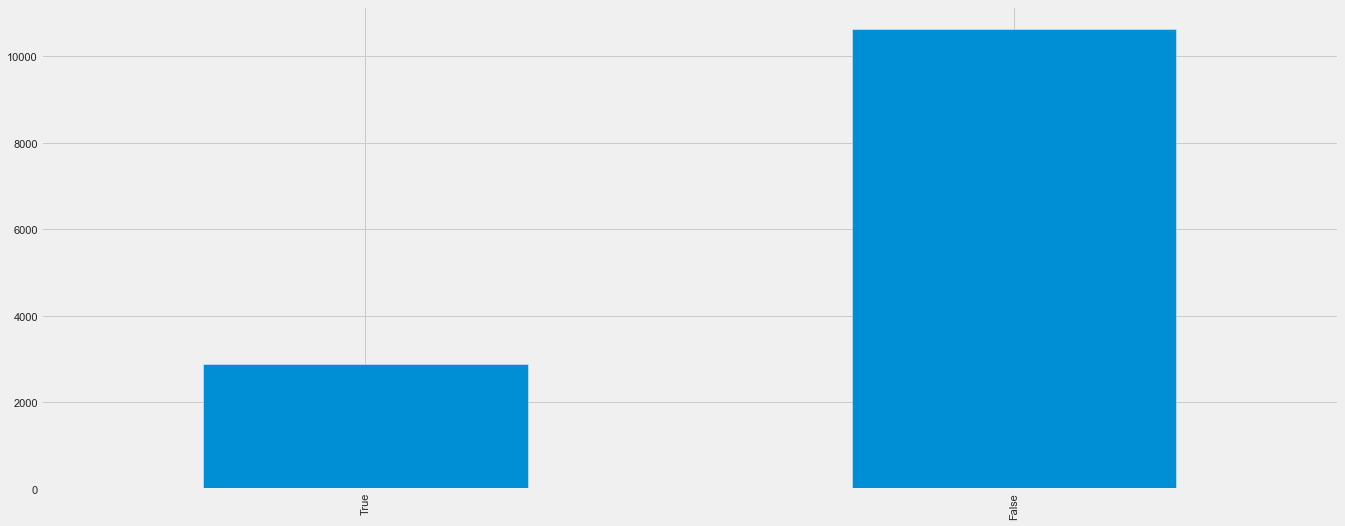

gym


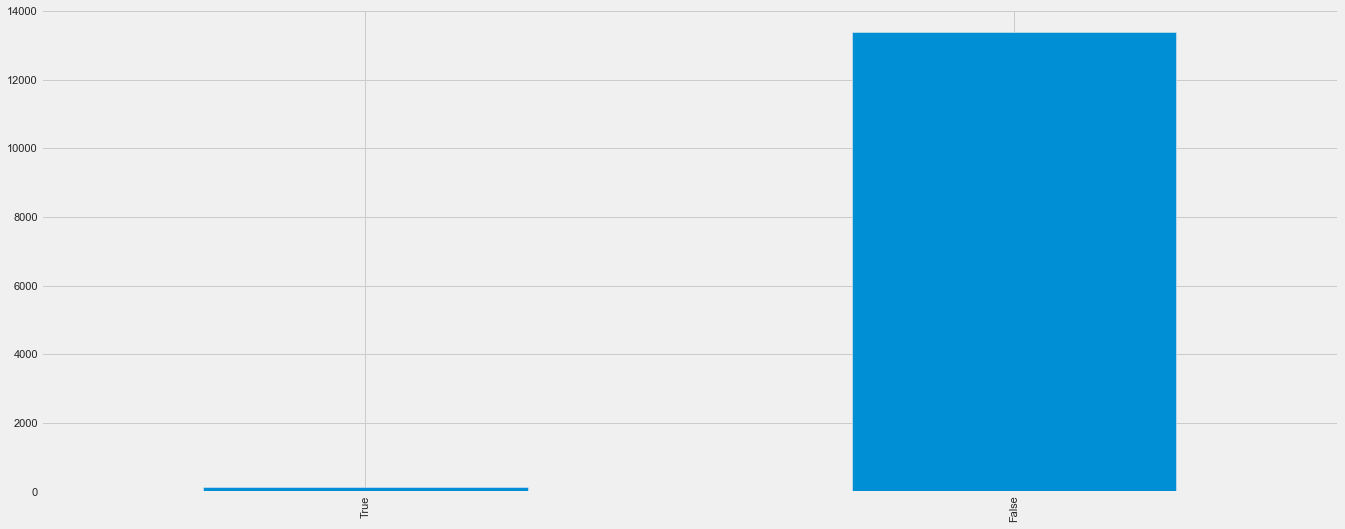

In [17]:
for i in cat:
    print(i)
    df[i].value_counts().sort_values().plot.bar()
    plt.show()

Masukin target (harga)

kamar_mandi


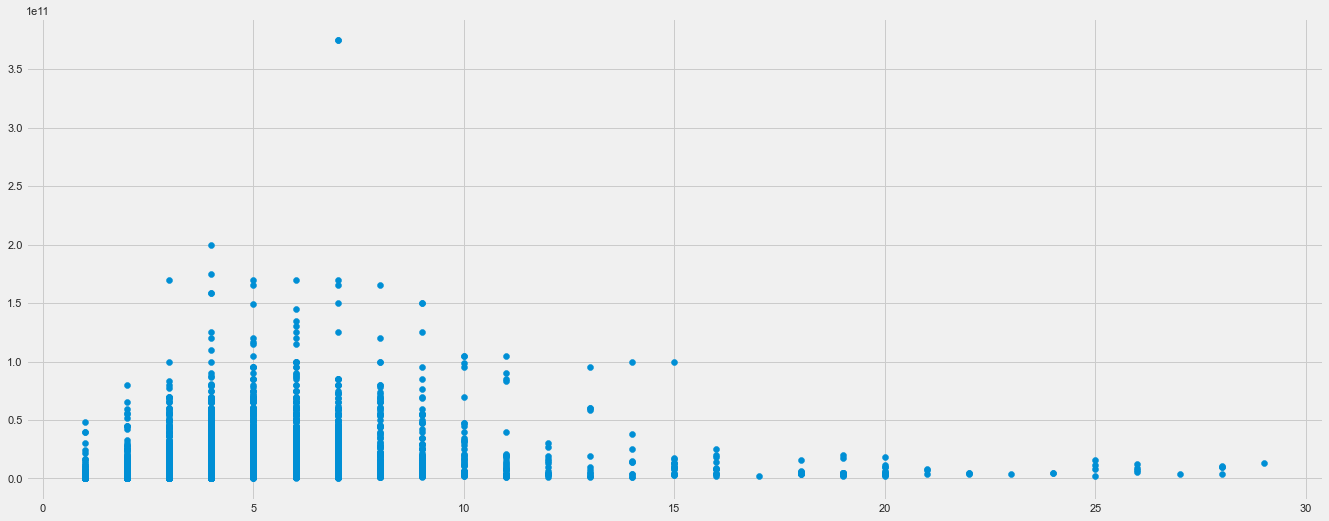

kamar_tidur


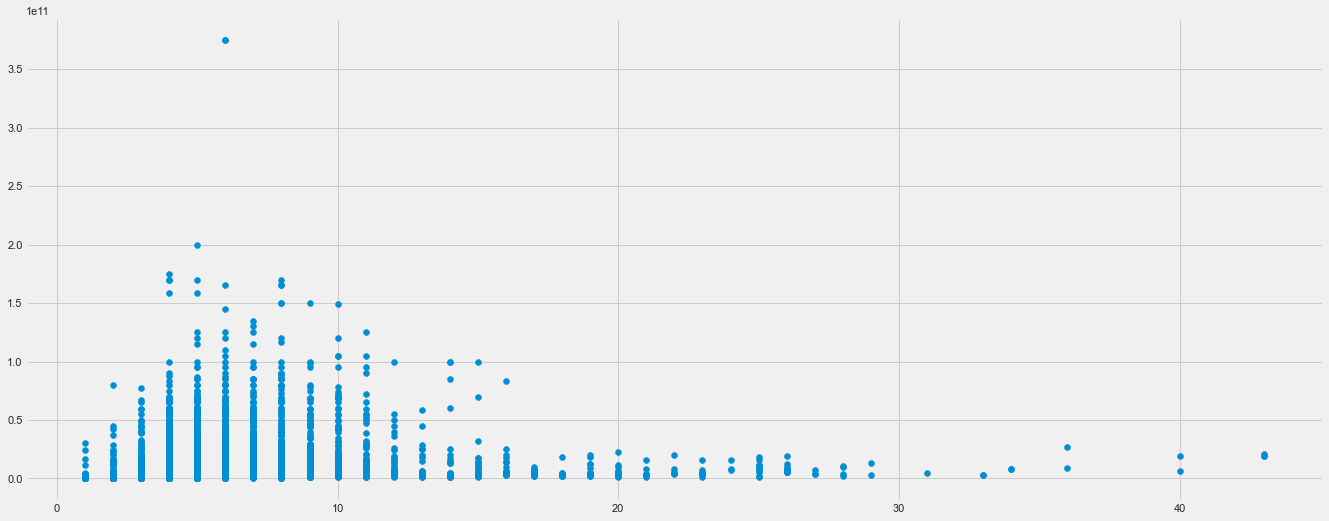

luas_bangunan


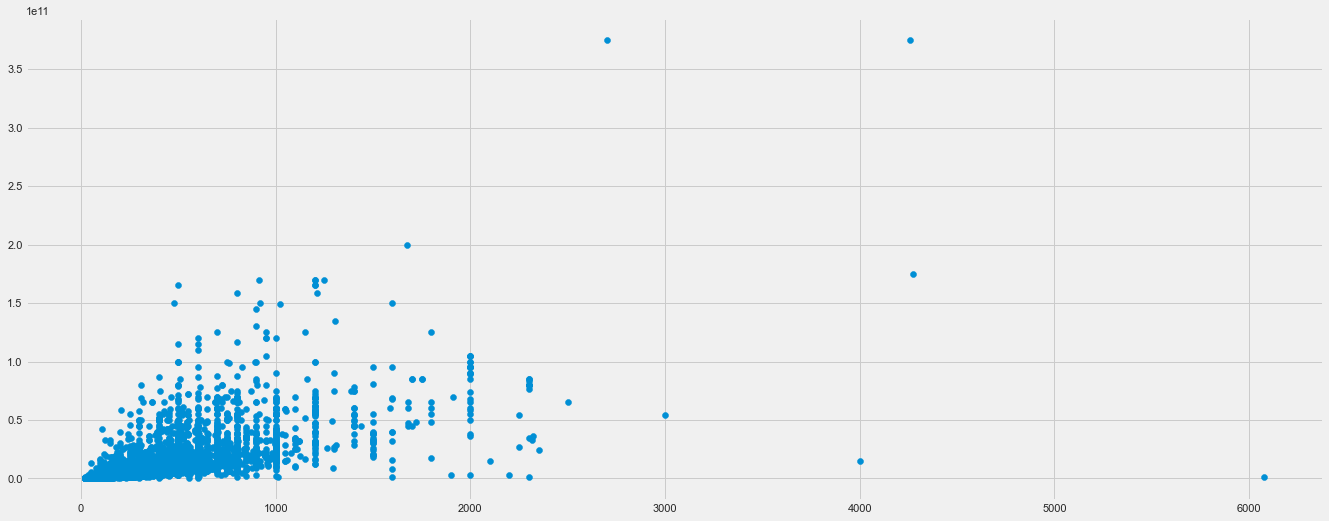

luas_tanah


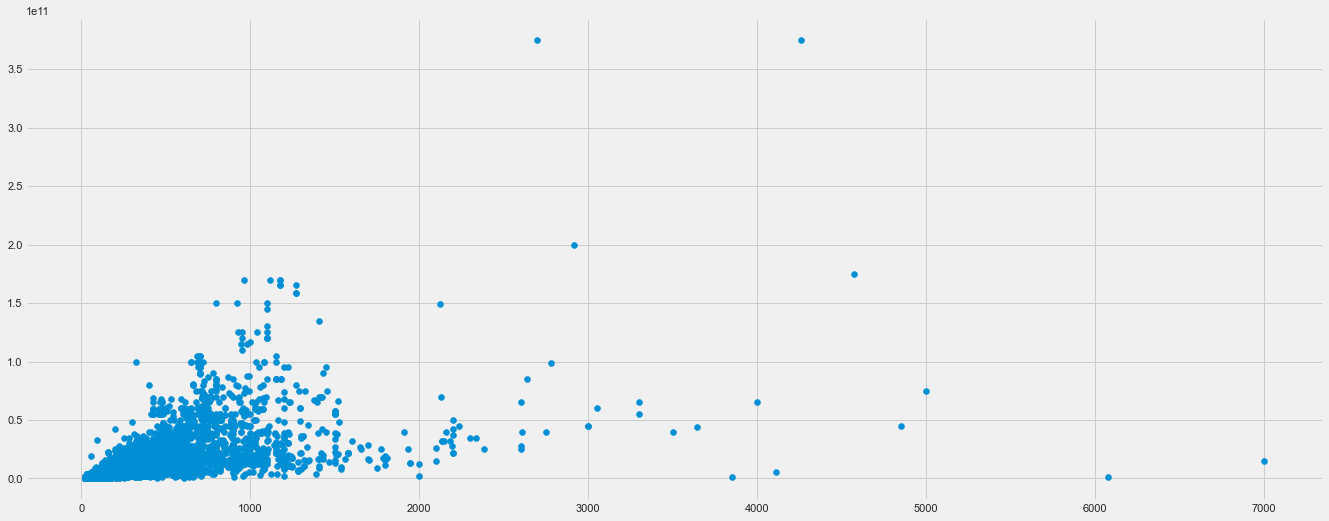

jumlah_lantai


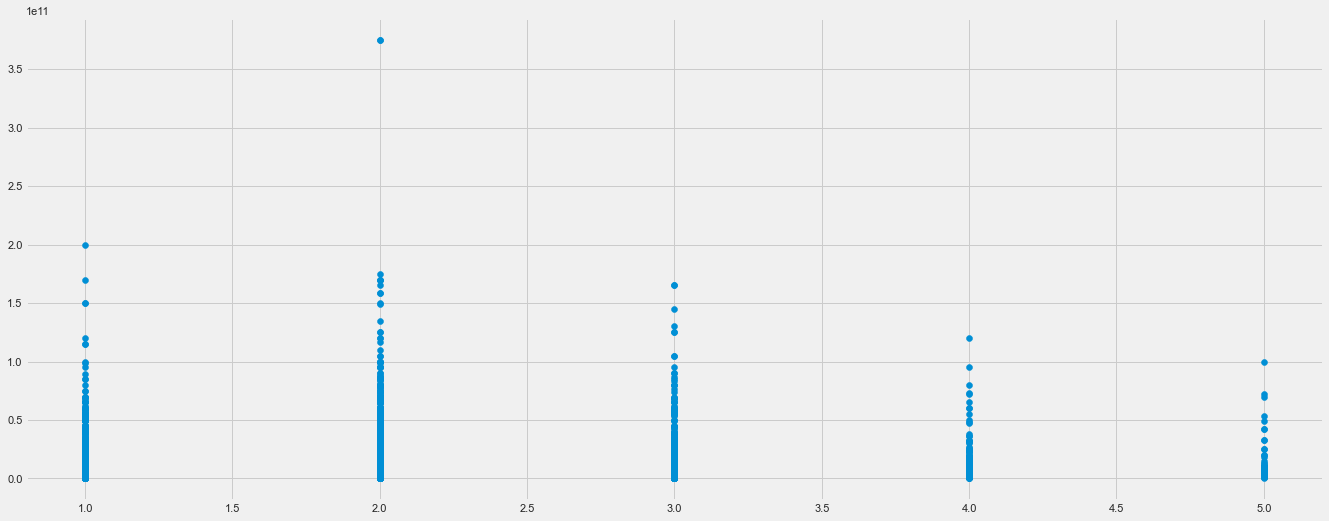

listrik


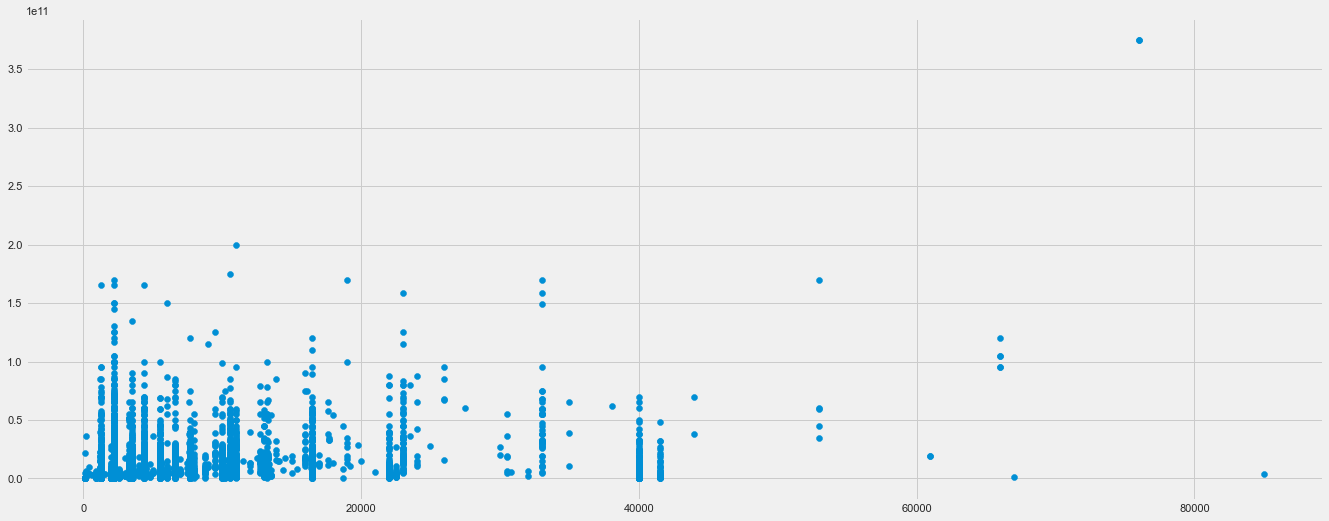

kecamatan


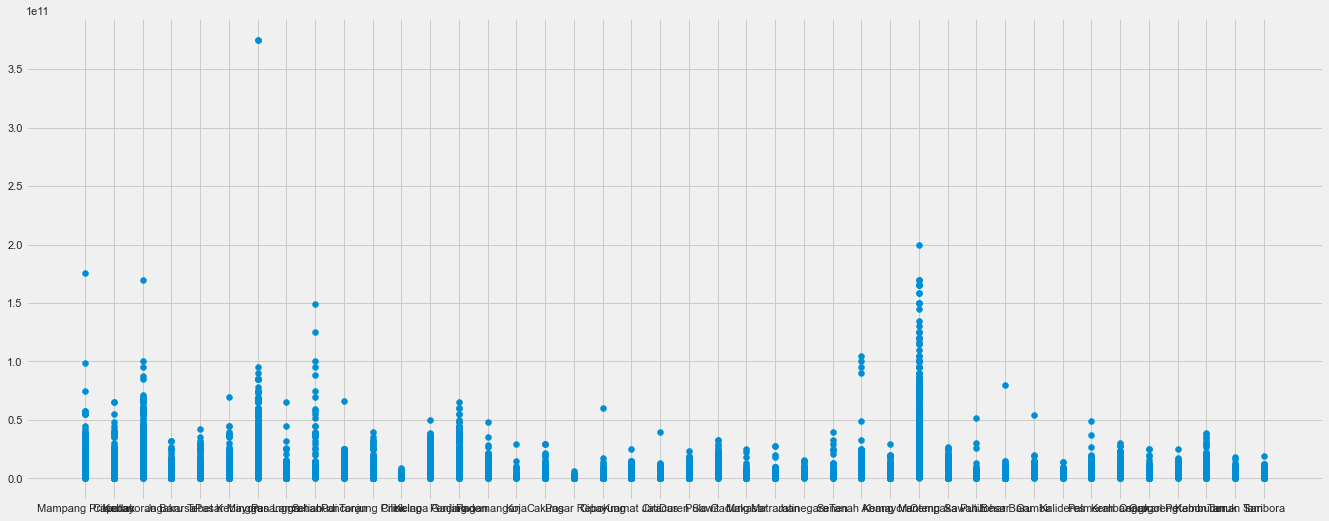

garasi


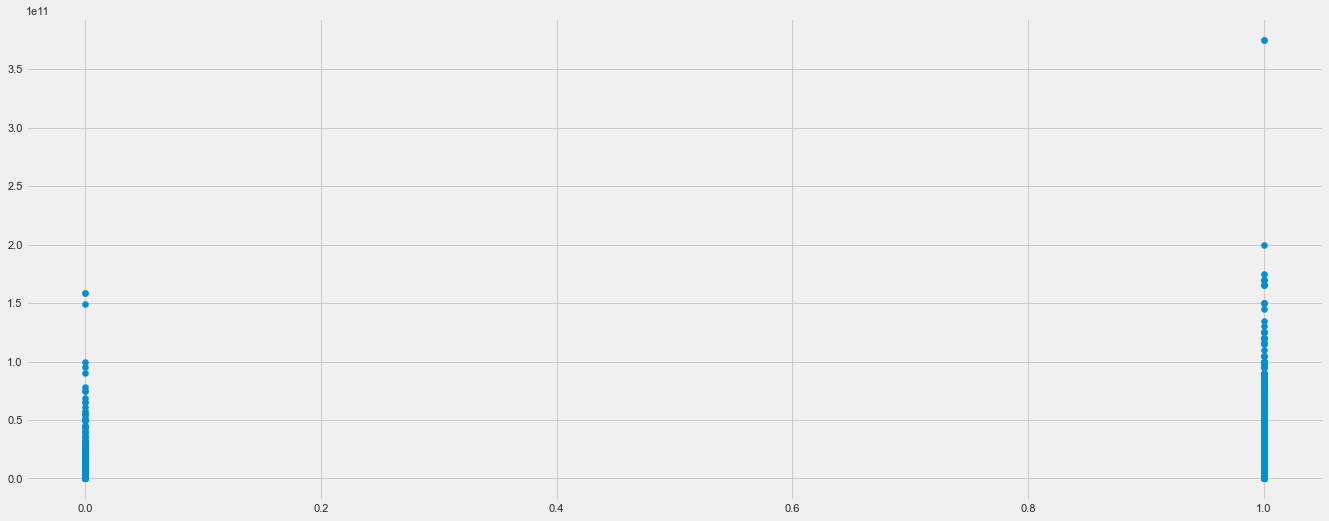

kolam_renang


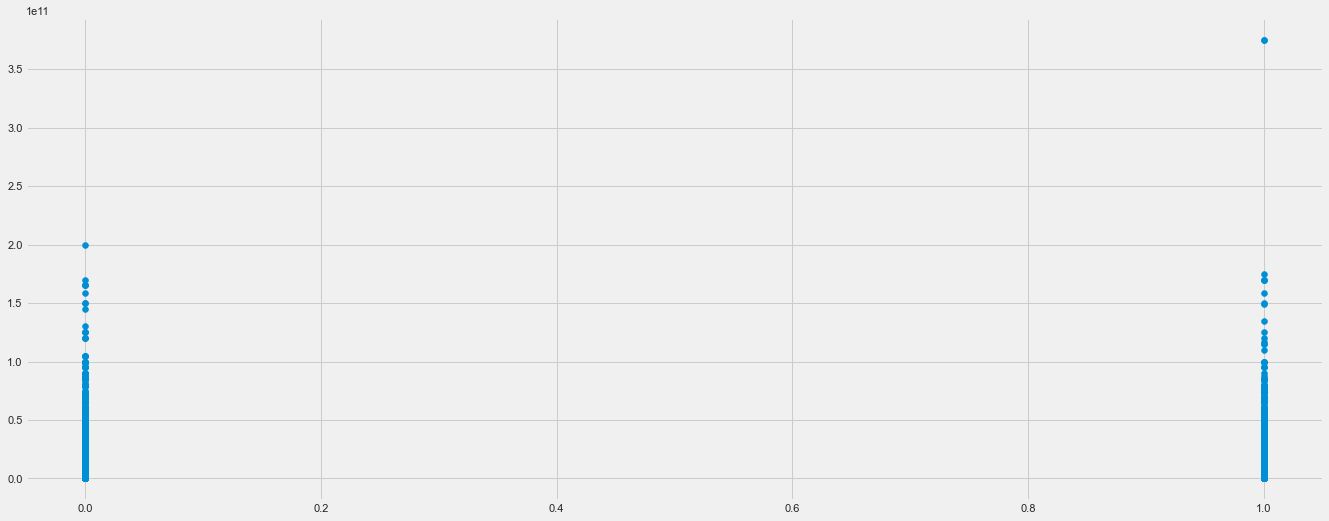

taman


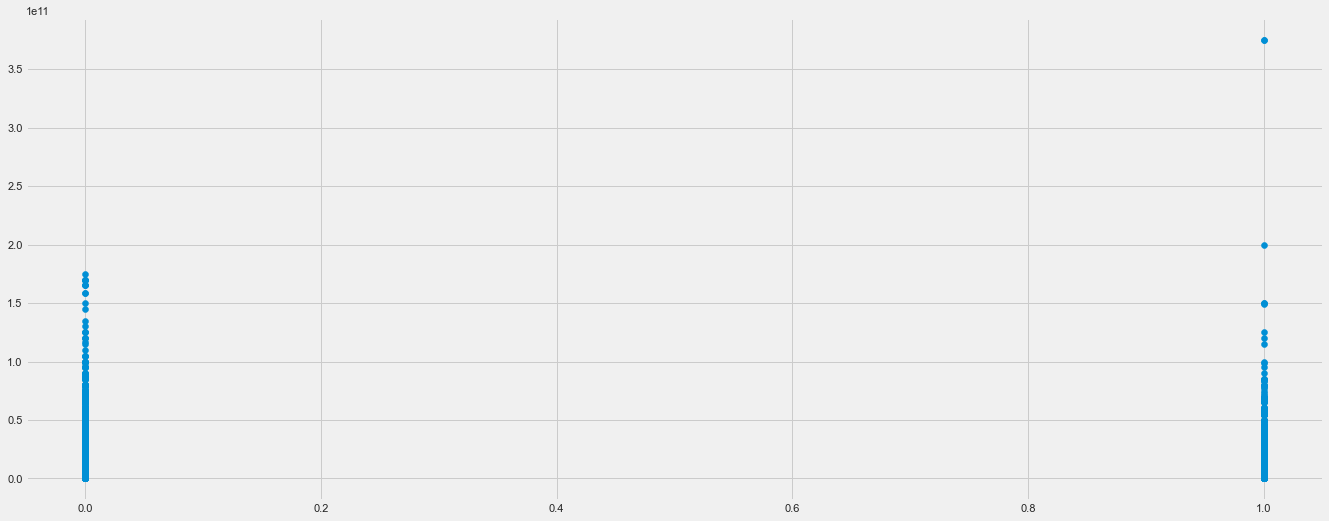

gym


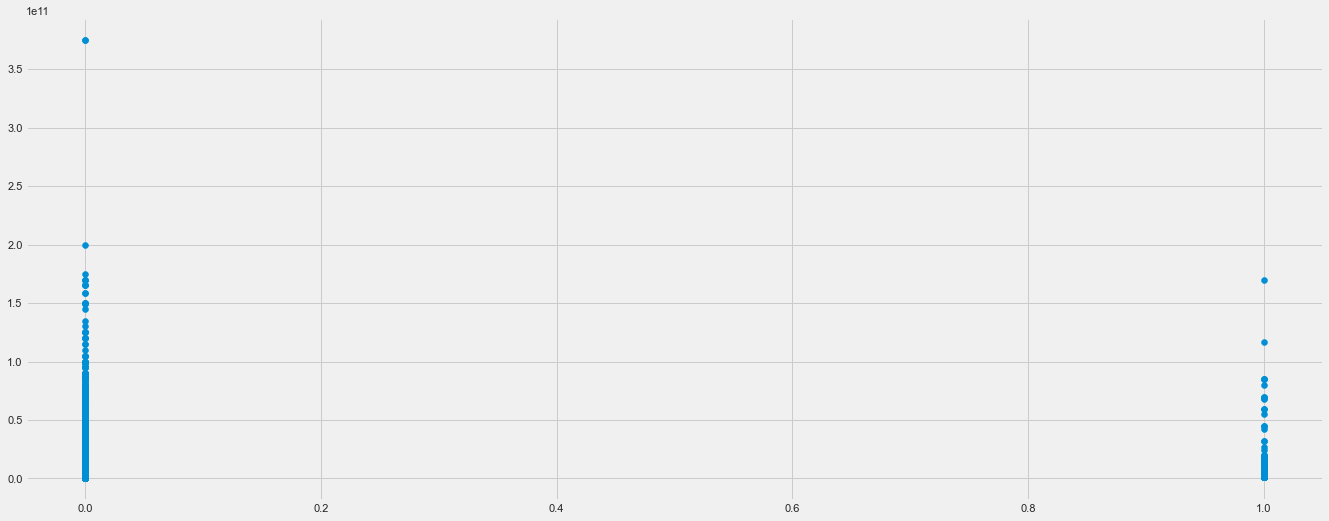

In [18]:
for i in num+cat:
    if i != 'harga':
        print(i)
        plt.scatter(df[i],df['harga'])
        plt.show()

kecamatan


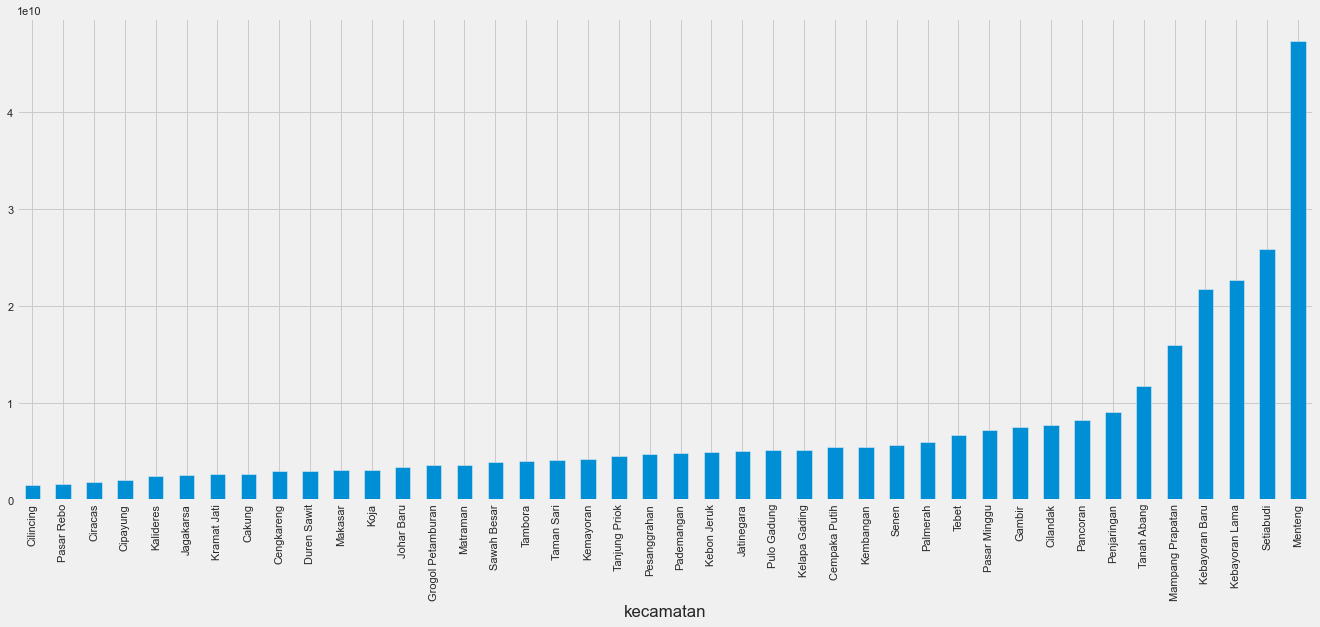

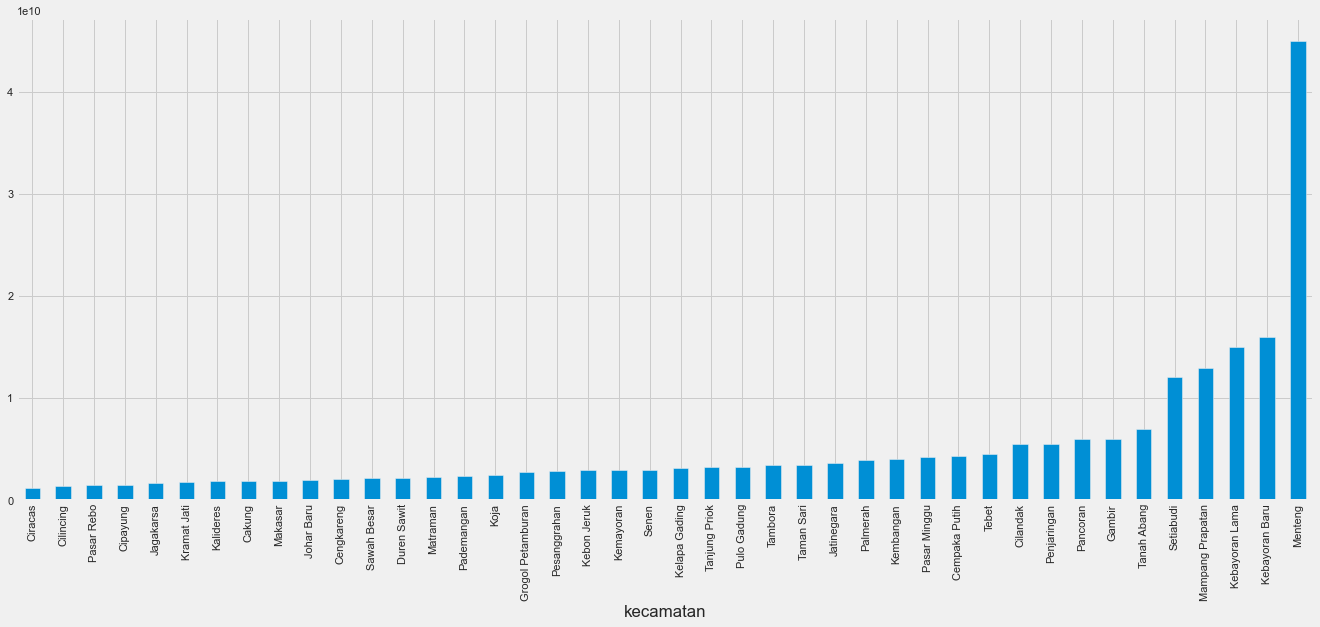

garasi


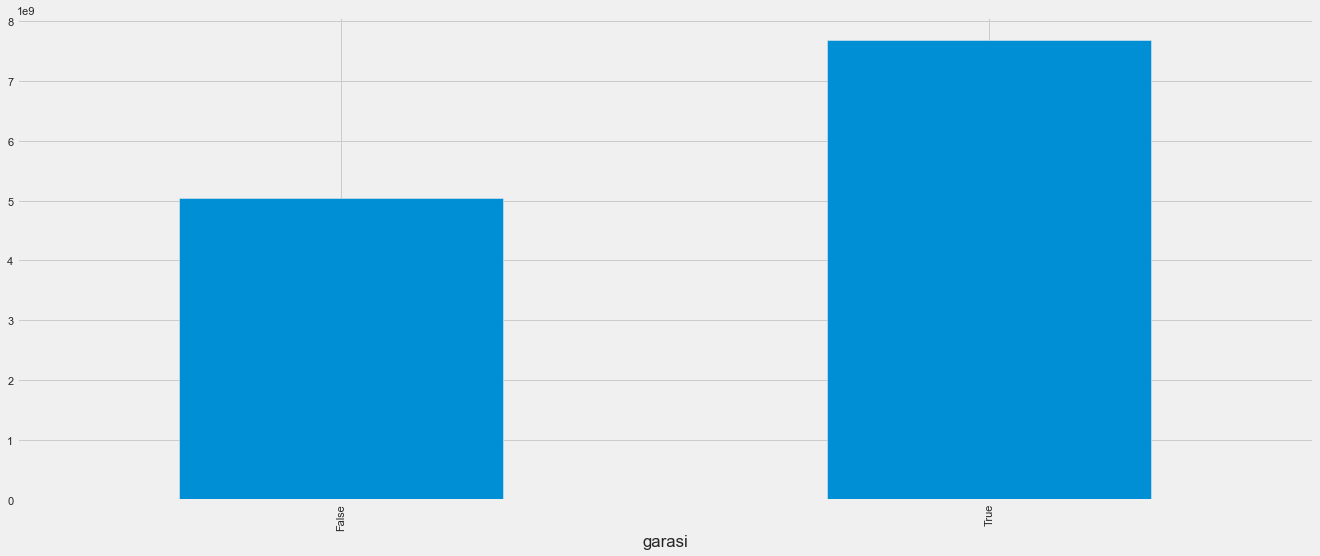

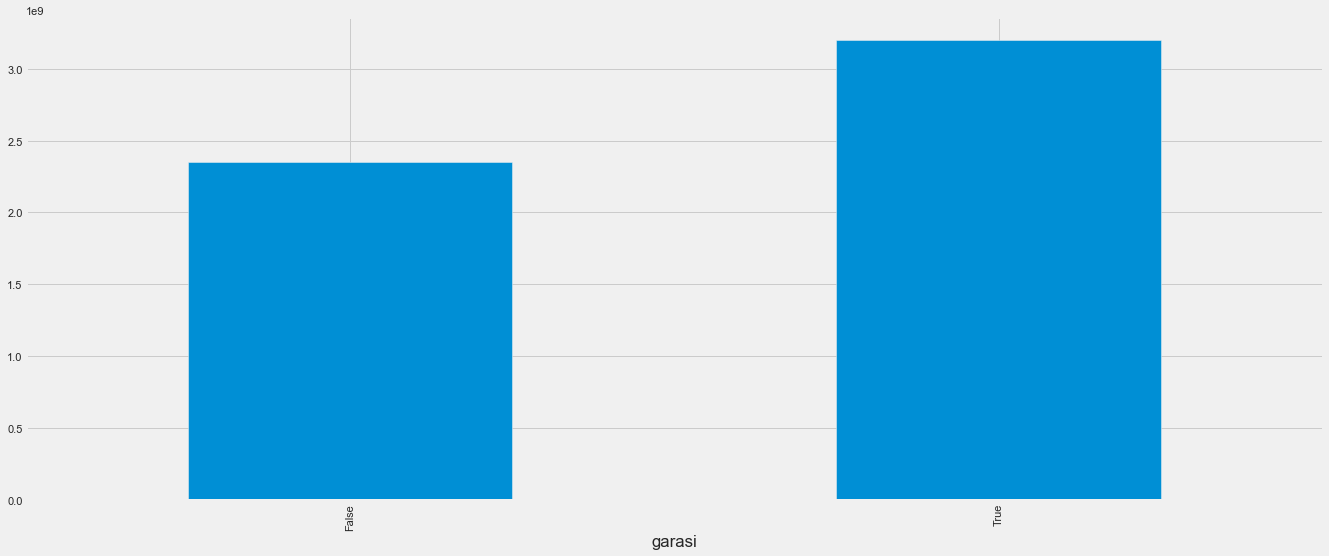

kolam_renang


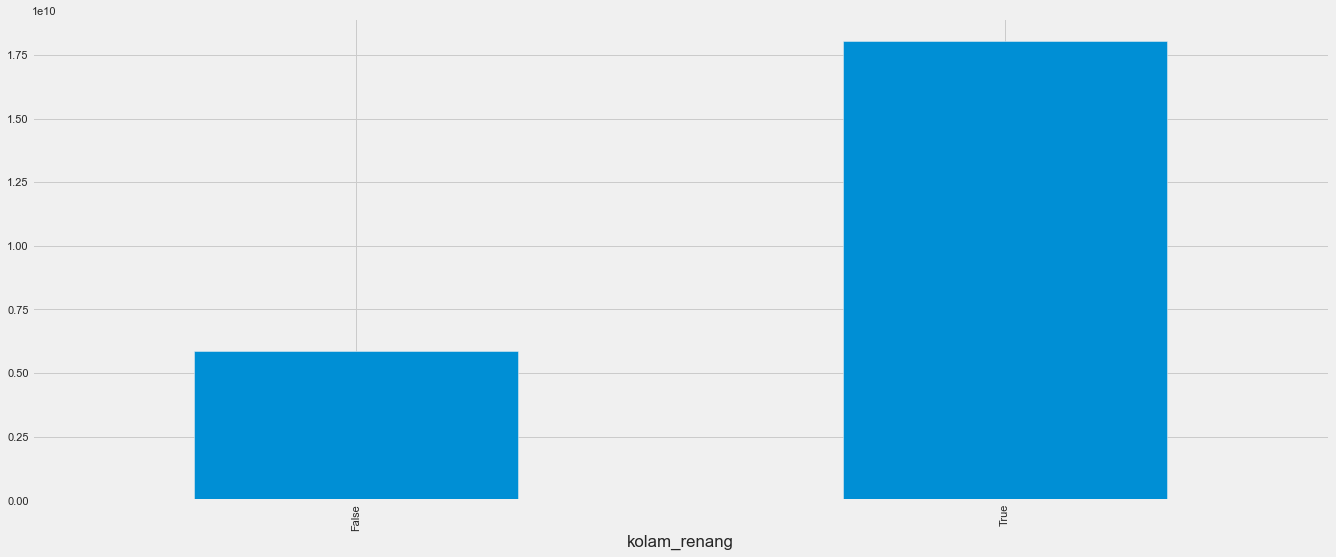

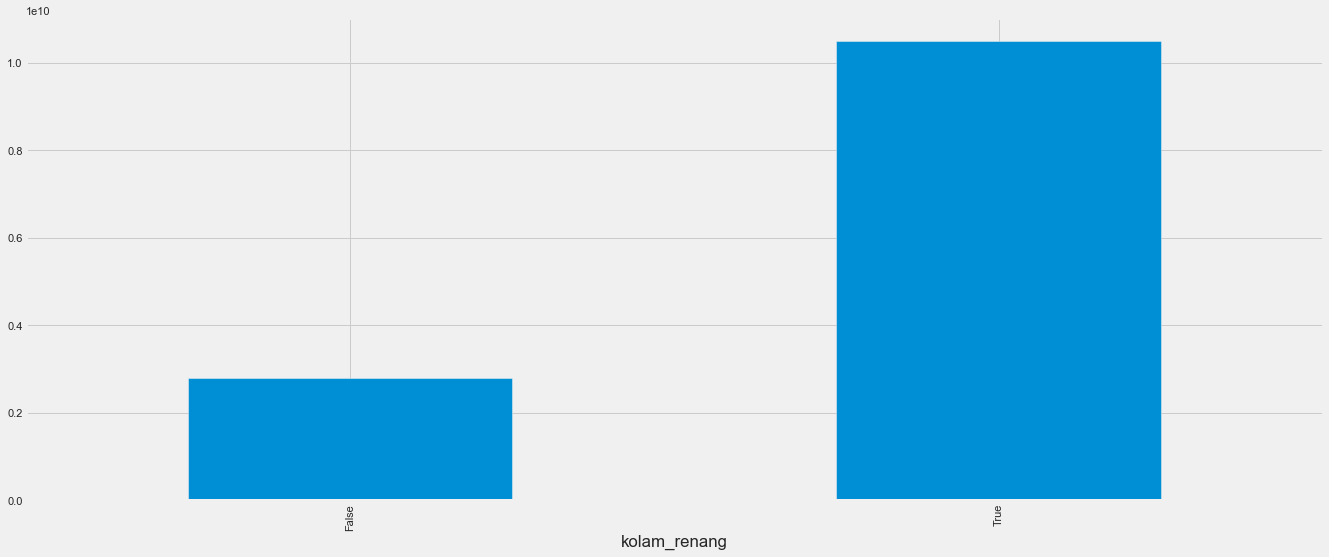

taman


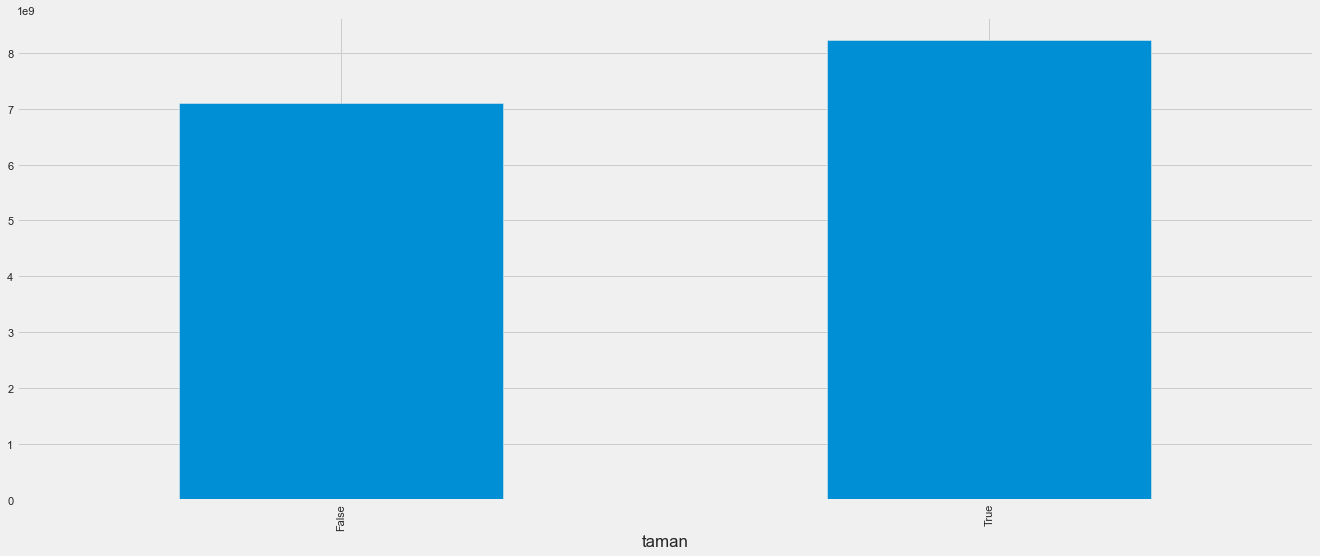

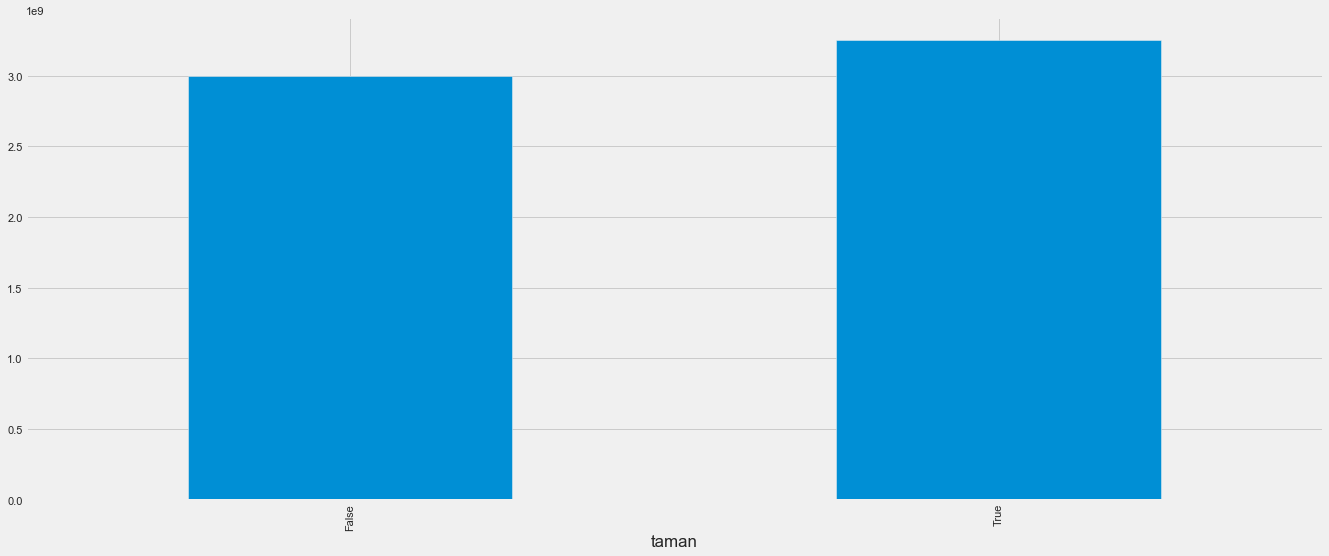

gym


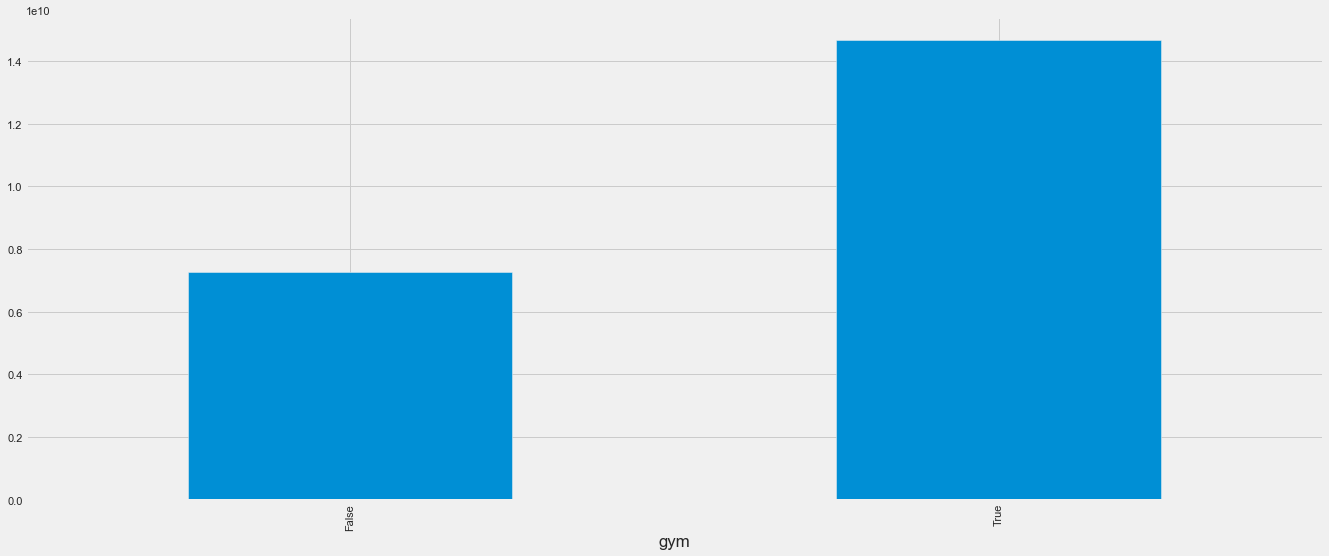

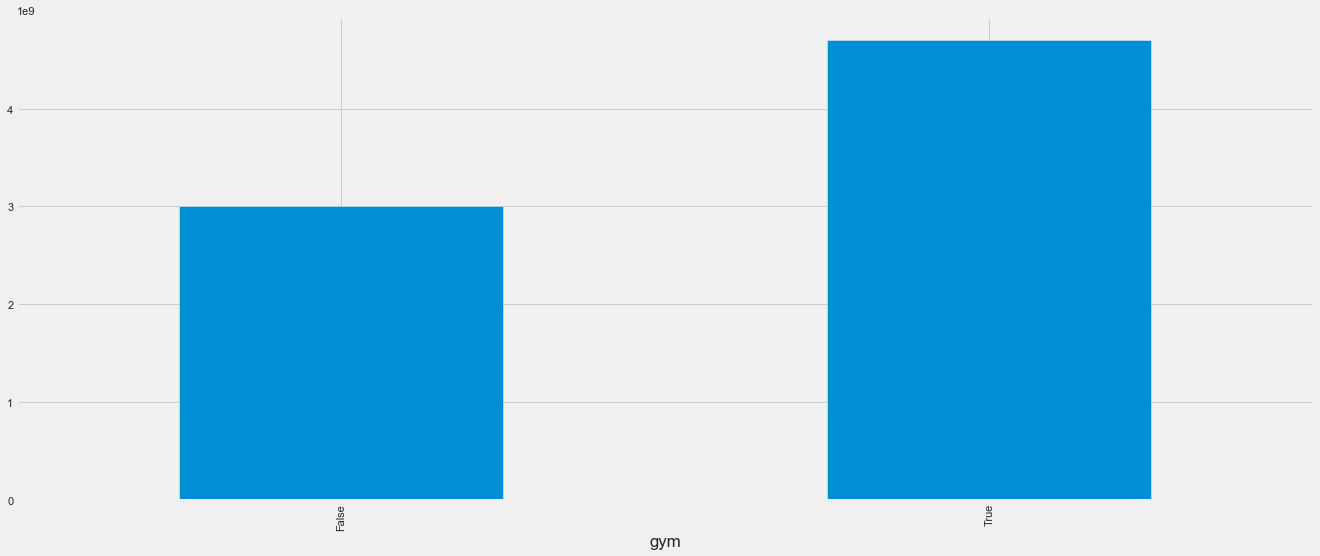

In [19]:
for i in cat:
    print(i)
    df.groupby(i)['harga'].mean().sort_values().plot.bar()
    plt.show()
    df.groupby(i)['harga'].median().sort_values().plot.bar()
    plt.show()

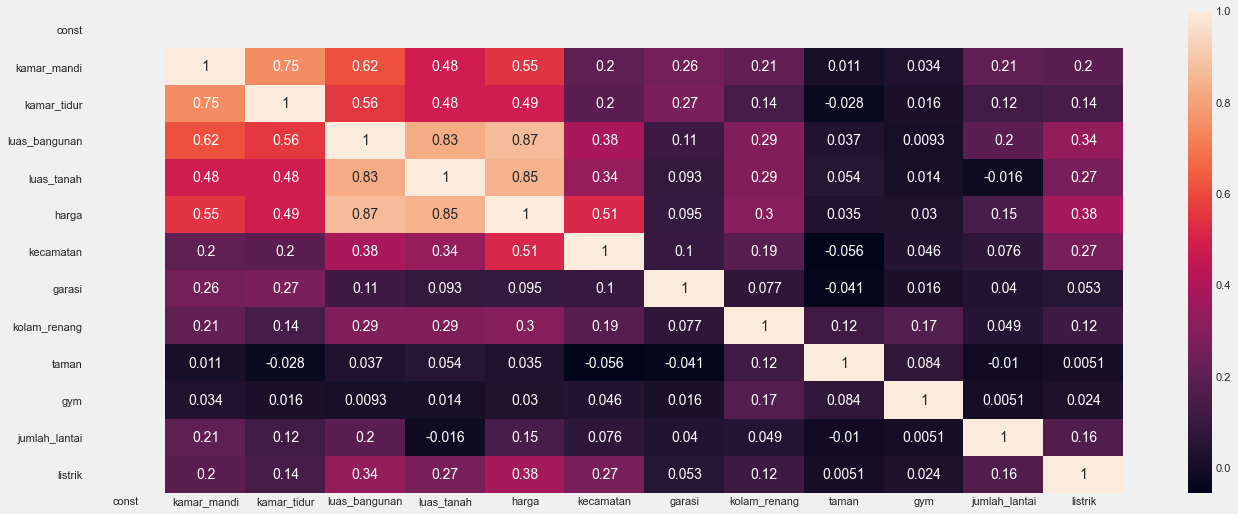

In [21]:
sns.heatmap(x.corr(method = 'spearman'),annot=True)
plt.show()